In [1]:
from xgboost import XGBClassifier
import warnings
from tabpfn import TabPFNClassifier
import numpy as np
import pandas as pd
import os
from evaluate import scores
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
import matplotlib.pyplot as plt
import torch
import openml
from tabularbench.data.synthetic_generator_forest import synthetic_dataset_generator_forest, synthetic_dataset_function_forest

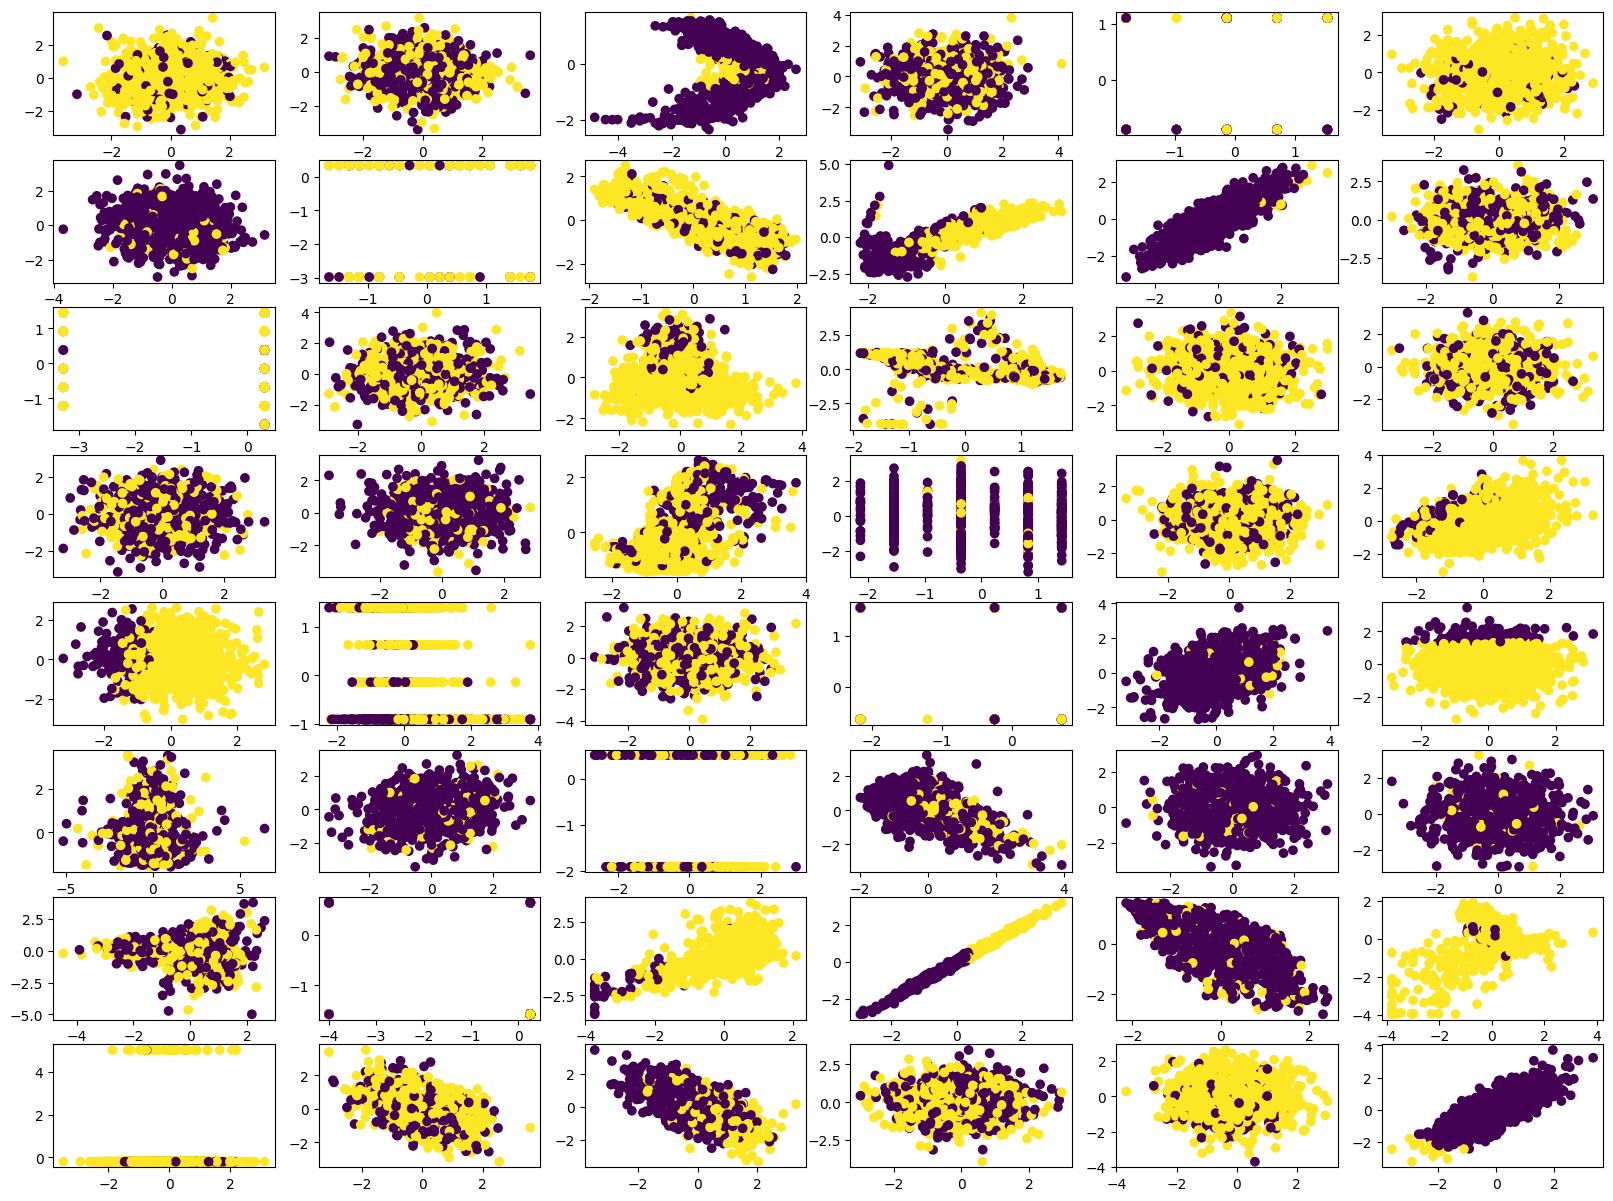

In [2]:
from tabularbench.data.synthetic_generator_tabpfn import synthetic_dataset_generator_tabpfn

fig, axes = plt.subplots(8, 6, figsize=(20, 15))
generator = synthetic_dataset_generator_tabpfn(n_samples=1000, max_classes=2, min_features=2, max_features=100)

for ax in axes.flatten():
    x2, b = next(generator)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    ax.scatter(x2[:, i1], x2[:, i2], c=b)

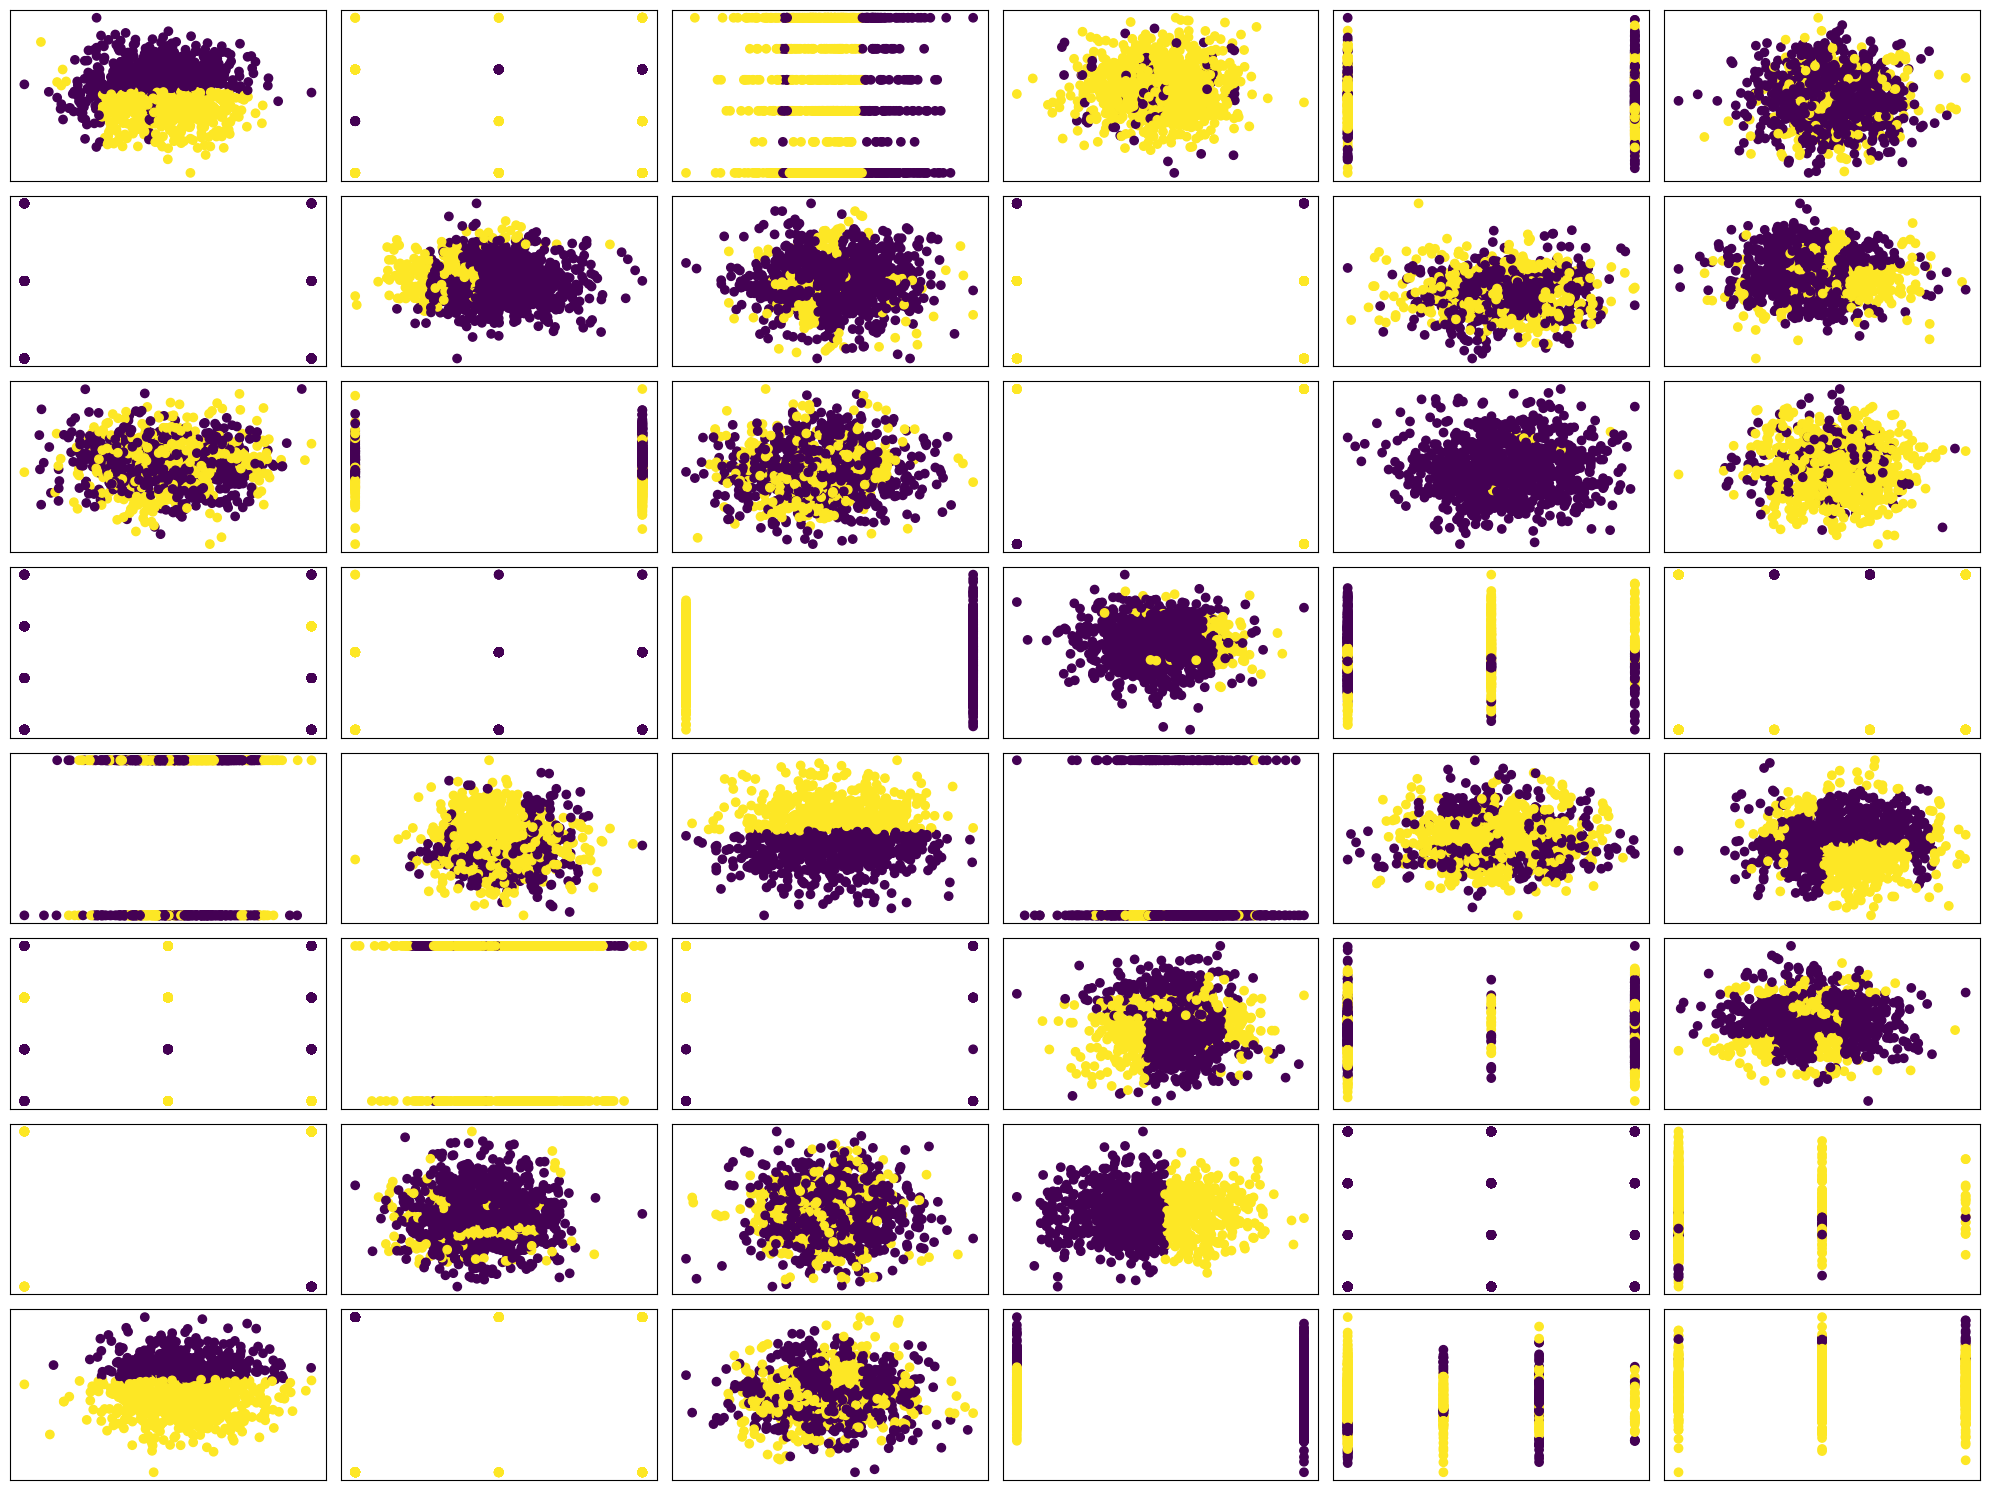

In [3]:
from tabularbench.data.synthetic_generator_forest import synthetic_dataset_generator_forest, synthetic_dataset_function_forest
import matplotlib

fig, axes = plt.subplots(8, 6, figsize=(20, 15))
generator = synthetic_dataset_generator_forest(n_samples=1000, max_classes=2, min_features=2, max_features=2)

cmap = matplotlib.colormaps['inferno']
colors = cmap(np.linspace(0.0, 0.9, 10))

for ax in axes.flatten():
    x2, b = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    random_shuffle = np.random.permutation(np.arange(10))
    colors_shuffle = colors[random_shuffle]
    #b = np.array([colors_shuffle[i] for i in b])
    ax.scatter(x2[:, i1], x2[:, i2], c=b)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

fig.tight_layout()

In [4]:
def zinb(size=(1000,100)):
    pi = 0.25
    p = np.random.uniform(0.1,0.9, size=size[1])
    p = np.repeat(np.expand_dims(p,axis=0),size[0],axis=0)
    #print
    #p += 1e-5
    X = np.random.negative_binomial(100,p)
    X = np.random.binomial(1,1-pi,size)*X
    return X

In [5]:
def zinb_comp(size=(1000,100)):
    X =  zinb(size)
    print(X)
    print(np.expand_dims(1/np.sum(X,axis=1),axis=1))
    return np.expand_dims(1/np.sum(X,axis=1),axis=1)*X

In [6]:
out = zinb_comp((10,10))
print(out)

[[  4   9  69 131 126  49   0 305 406  13]
 [  8  18  63 113 162  55 285   0 402   0]
 [  0   8   0   0   0  67 263   0   0  11]
 [  9   8   0 104 112  53 295 440   0   0]
 [ 14   0  81 107 112  63 323 497   0  19]
 [  0  14   0 114 132  48 374 494 361   0]
 [  0   9  81 154 119  40 225 392 348  12]
 [ 13   7  89 128 115  54 305 405   0  16]
 [ 14  12  77  91 106  60   0   0 365   9]
 [  0  13  86 133   0   0   0   0 380  11]]
[[0.00089928]
 [0.00090416]
 [0.00286533]
 [0.00097943]
 [0.00082237]
 [0.00065062]
 [0.00072464]
 [0.00088339]
 [0.0013624 ]
 [0.00160514]]
[[0.00359712 0.00809353 0.06205036 0.11780576 0.11330935 0.04406475
  0.         0.27428058 0.36510791 0.01169065]
 [0.00723327 0.01627486 0.05696203 0.10216998 0.14647378 0.04972875
  0.25768535 0.         0.36347197 0.        ]
 [0.         0.02292264 0.         0.         0.         0.19197708
  0.75358166 0.         0.         0.03151862]
 [0.00881489 0.00783546 0.         0.10186092 0.10969638 0.05190989
  0.28893242 0.

In [7]:
print(np.sum(out, axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


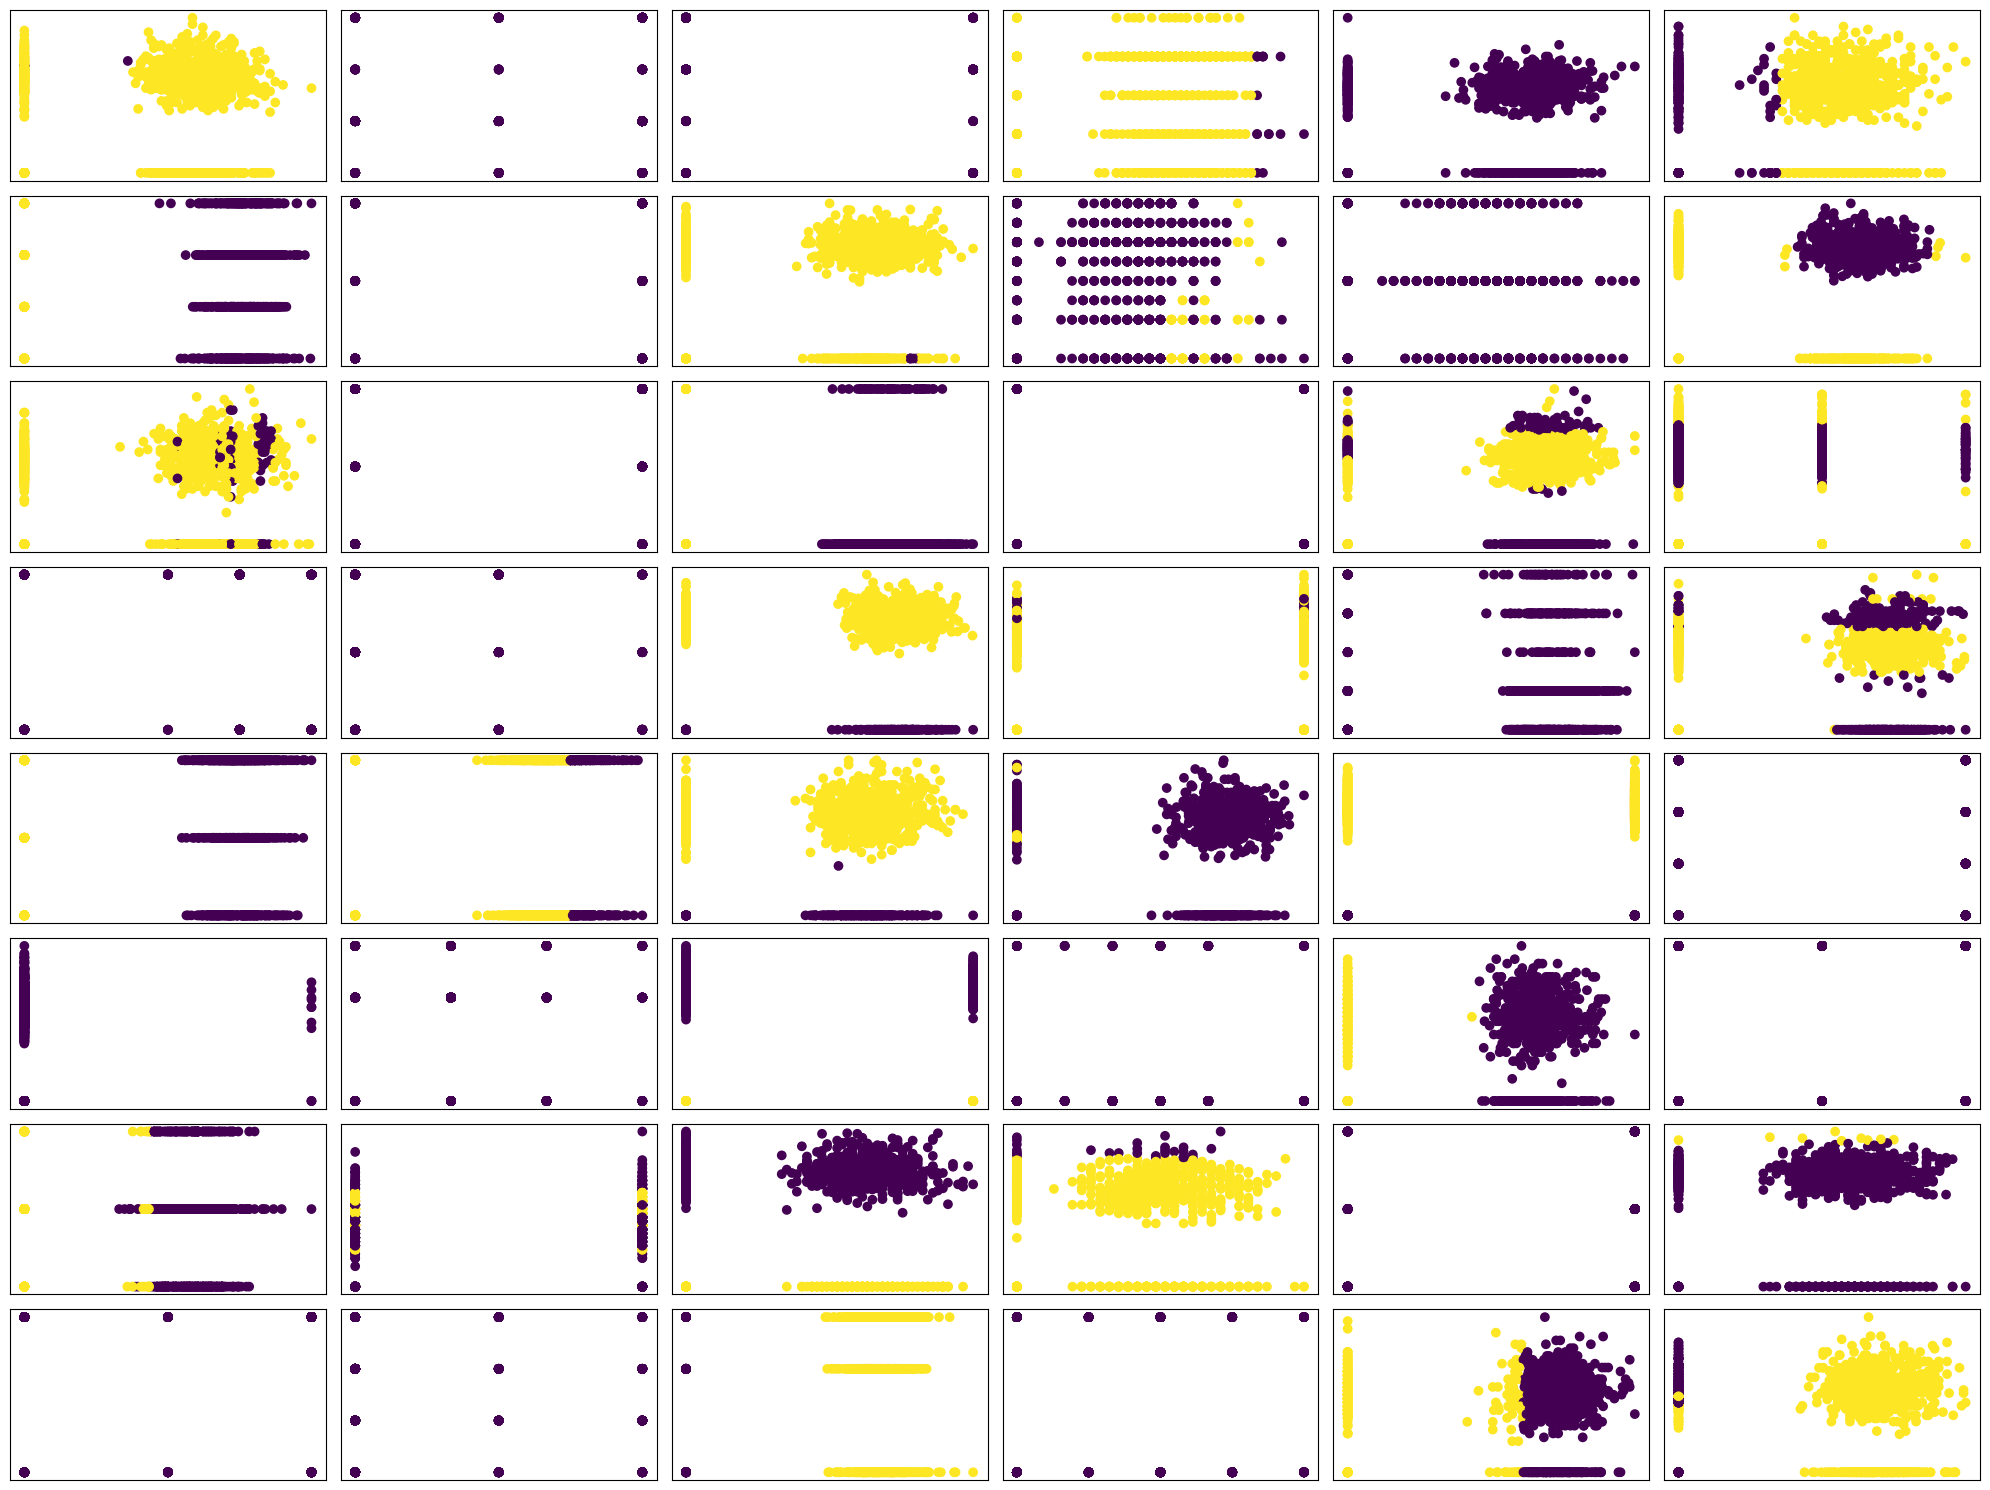

In [8]:
from prior.synthetic_generator_forest_altdata import synthetic_dataset_generator_forest_altdata, synthetic_dataset_function_forest_altdata

fig, axes = plt.subplots(8, 6, figsize=(20, 15))

cmap = matplotlib.colormaps['inferno']
colors = cmap(np.linspace(0.0, 0.9, 10))



for ax in axes.flatten():
    x2, b = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    random_shuffle = np.random.permutation(np.arange(10))
    colors_shuffle = colors[random_shuffle]
    #b = np.array([colors_shuffle[i] for i in b])
    ax.scatter(x2[:, i1], x2[:, i2], c=b)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

fig.tight_layout()

In [9]:

X_norm, b_norm = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)

X_zinb, b_zinb = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
accuracy = np.zeros((3))
runs = 10
for ii in range(runs):
    X_norm, b_norm = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    models = [XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'), 
              LogisticRegression(max_iter=500), 
              TabPFNClassifier(device='cpu', N_ensemble_configurations=3)]
    X_train, X_test, y_train, y_test = train_test_split(X_norm, b_norm, test_size=0.2, random_state=42)
    for mm, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy[mm] += accuracy_score(y_test,y_pred)
print(accuracy/runs)

C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
accuracy = np.zeros((3))
runs = 10
for ii in range(runs):
    print(ii)
    X_zinb, b_zinb = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    models = [XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'), 
              LogisticRegression(max_iter=500), 
              TabPFNClassifier(device='cpu', N_ensemble_configurations=3)]
    X_train, X_test, y_train, y_test = train_test_split(X_zinb, b_zinb, test_size=0.2, random_state=42)
    for mm, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy[mm] += accuracy_score(y_test,y_pred)
print(accuracy/runs)